In [48]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [49]:
# Biomass characteristics as given by de Medeiros et al., 2017 - 10.1016/j.jclepro.2017.01.165
ultimate = [46.96, 5.72, 44.05, 0.27, 0.04, 0.02] # d.b.
ash = 2.94 / 100 # d.b.
moist = 50.00 / 100 # d.b.
HHV = 18.5 # MJ/kg, d.b.
fuel = fs.create_fuel_stream(1, ultimate, ash, moist, HHV)

In [50]:
stoichAir = fs.create_air_from_ER(fuel, 1.0)
stoichAirMass = stoichAir.get_mass()
stoichOxygen = fs.create_O2_from_ER(fuel, 1.0)
stoichOxygenMass = stoichOxygen.get_mass()

In [51]:
T0 = 298.15
P0 = ct.one_atm

ERs = np.arange(0.0, 1.0+1E-9, 0.01)
outs_by_ER = []

for i, er in enumerate(ERs):
    air = fs.create_air_from_ER(fuel, er)
    outlet = gs.gasify_nonisot(fuel, air, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_ER.append(outlet)

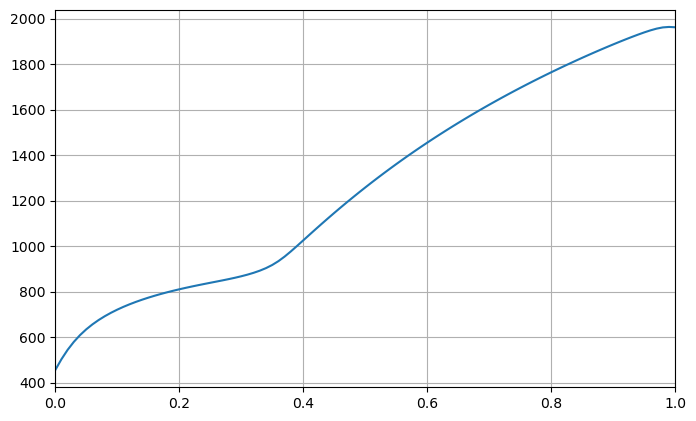

In [52]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [out.T for out in outs_by_ER])
plt.xlim(ERs[0],ERs[-1])
plt.grid()
plt.show()

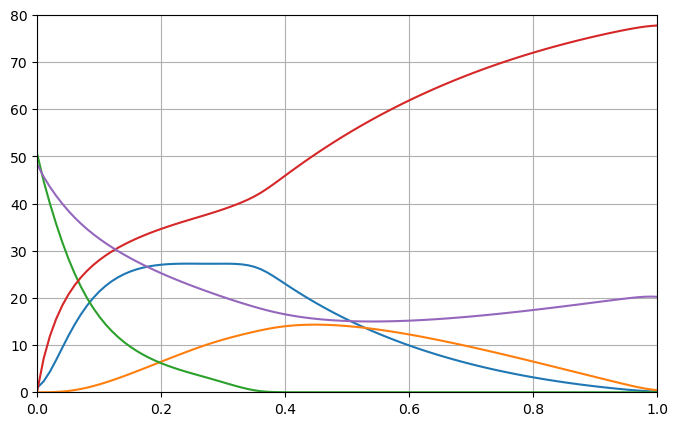

In [53]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [100*out.get_syngas_fraction('H2', water=False, nitrogen=True) for out in outs_by_ER])
plt.plot(ERs, [100*out.get_syngas_fraction('CO', water=False, nitrogen=True) for out in outs_by_ER])
plt.plot(ERs, [100*out.get_syngas_fraction('CH4', water=False, nitrogen=True) for out in outs_by_ER])
plt.plot(ERs, [100*out.get_syngas_fraction('N2', water=False, nitrogen=True) for out in outs_by_ER])
plt.plot(ERs, [100*out.get_syngas_fraction('CO2', water=False, nitrogen=True) for out in outs_by_ER])
plt.xlim(ERs[0],ERs[-1])
plt.ylim(0, 80)
plt.grid()
plt.show()

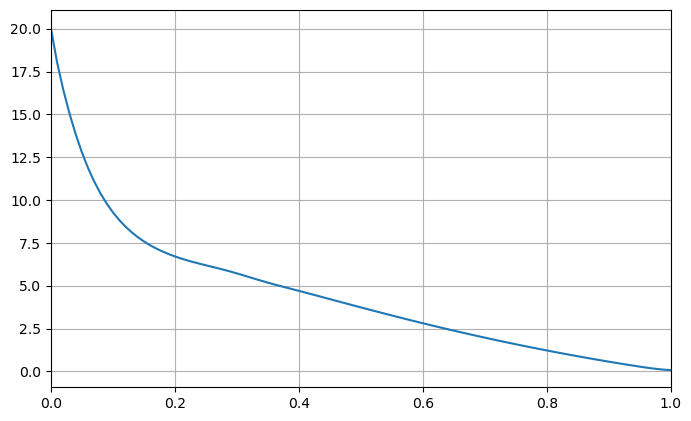

In [54]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outs_by_ER])
plt.xlim(ERs[0],ERs[-1])
plt.grid()
plt.show()

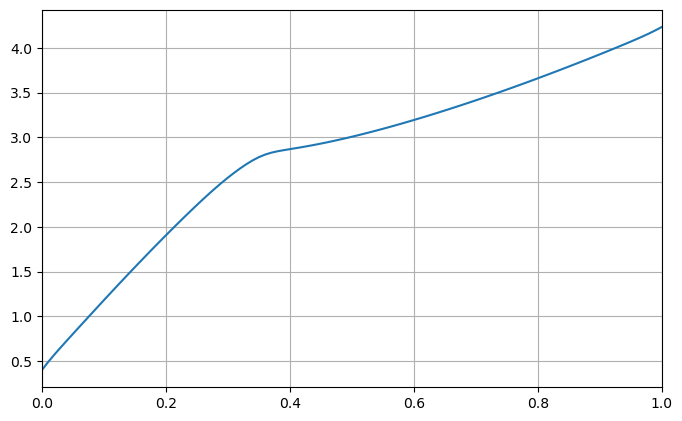

In [55]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outs_by_ER])
plt.xlim(ERs[0],ERs[-1])
plt.grid()
plt.show()

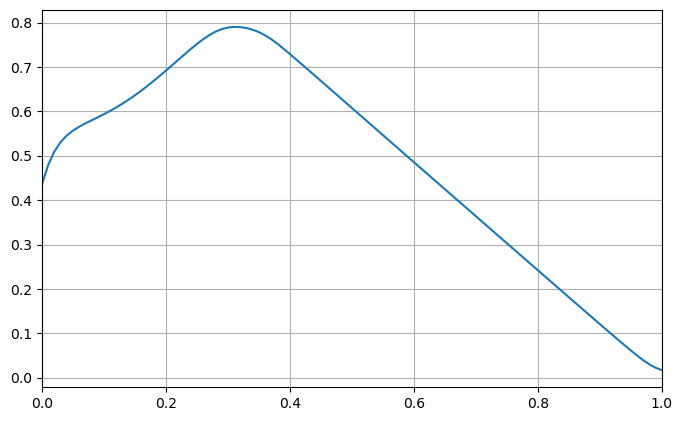

In [56]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [out.get_syngas_CGE() for out in outs_by_ER])
plt.xlim(ERs[0],ERs[-1])
plt.grid()
plt.show()

In [57]:
CGEs = [out.get_syngas_CGE() for out in outs_by_ER]
optCGE = max(CGEs)
optIndex = CGEs.index(optCGE)
optER = ERs[optIndex]
optAir = fs.create_air_from_ER(fuel, optER)
print(optCGE, optER)

0.7901918812079496 0.31


In [58]:
Ps = np.arange(0.1, 10+1E-9, 0.1) * ct.one_atm
outs_by_P = []

for i, p in enumerate(Ps):
    outlet = gs.gasify_nonisot(fuel, optAir, T0=T0, P=p, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_P.append(outlet)

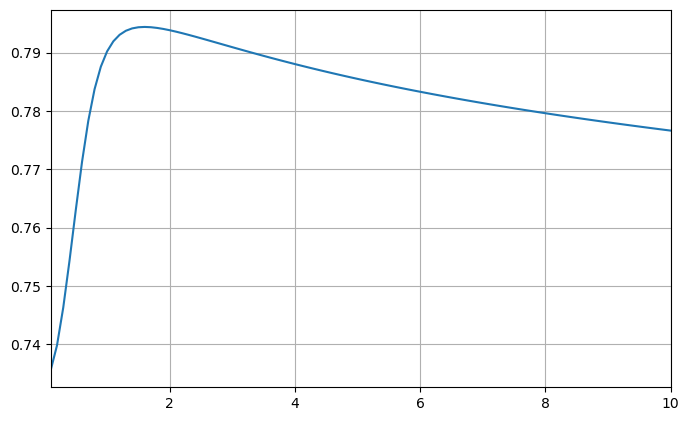

In [59]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(Ps/ct.one_atm, [out.get_syngas_CGE() for out in outs_by_P])
plt.xlim(Ps[0]/ct.one_atm,Ps[-1]/ct.one_atm)
plt.grid()
plt.show()

In [60]:
moists = np.arange(0, 100+1e-9, 1) / 100
outs_by_moist = []

for i, m in enumerate(moists):
    fuel.set_moisture(m)
    outlet = gs.gasify_nonisot(fuel, optAir, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_moist.append(outlet)

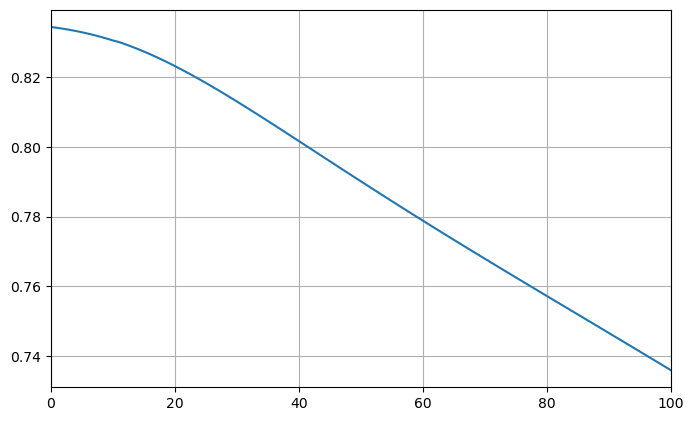

In [61]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(moists*100, [out.get_syngas_CGE() for out in outs_by_moist])
plt.xlim(moists[0]*100,moists[-1]*100)
plt.grid()
plt.show()

In [62]:
def CGE(x):
    T0 = 298.15
    ER, SR = x
    P_atm = 1
    P = P_atm * ct.one_atm
    moistDB = 50 / 100
    # Biomass characteristics as given by de Medeiros et al., 2017 - 10.1016/j.jclepro.2017.01.165
    ultimate = [46.96, 5.72, 44.05, 0.27, 0.04, 0.02] # d.b.
    ash = 2.94 / 100 # d.b.
    HHV = 18.5 # MJ/kg, d.b.
    fuel = fs.create_fuel_stream(1, ultimate, ash, moistDB, HHV)
    
    air = fs.create_air_from_ER(fuel, ER)
    steam = fs.create_steam_stream(SR * fuel.get_mass())
    agent = fs.combine_streams(air, steam)

    outlet = gs.gasify_nonisot(fuel, agent, T0, P, heatLossFraction=0, charFormation=0, directMethaneConv=0)

    return -outlet.get_syngas_CGE()

x0 = [0.31, 1]
print(CGE(x0))

sol = opt.minimize(CGE, x0, bounds=[(0,1),(0,np.inf)])
print(sol)

-0.7790978840509147
      fun: -0.9521406924360626
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.60868185e-01, -7.28306761e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 19
     njev: 25
   status: 0
  success: True
        x: array([ 0.        , 82.26410264])


In [63]:
print(CGE([0, 100]))
print(CGE([0, 82]))

-0.9522574534976708
-0.9521387439530091


In [67]:
SRs = np.arange(0, 10+1E-9, 0.1)
outs_by_SR = []

for i, sr in enumerate(SRs):
    steam = fs.create_steam_stream(sr*fuel.get_mass())
    outlet = gs.gasify_nonisot(fuel, steam, T0=473.15, P=P0, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_SR.append(outlet)

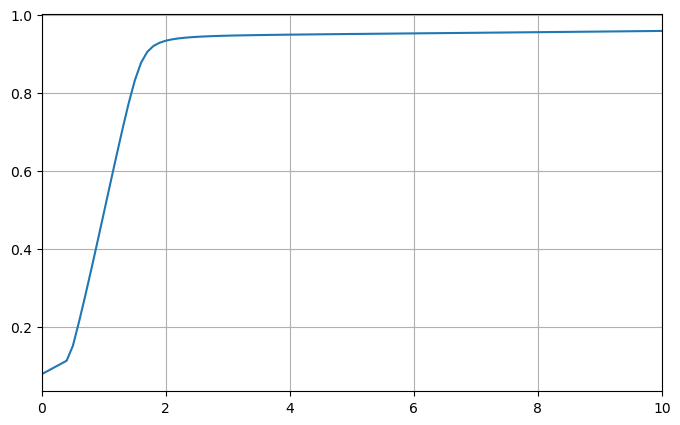

In [68]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(SRs, [out.get_syngas_CGE() for out in outs_by_SR])
plt.xlim(SRs[0],SRs[-1])
plt.grid()
plt.show()

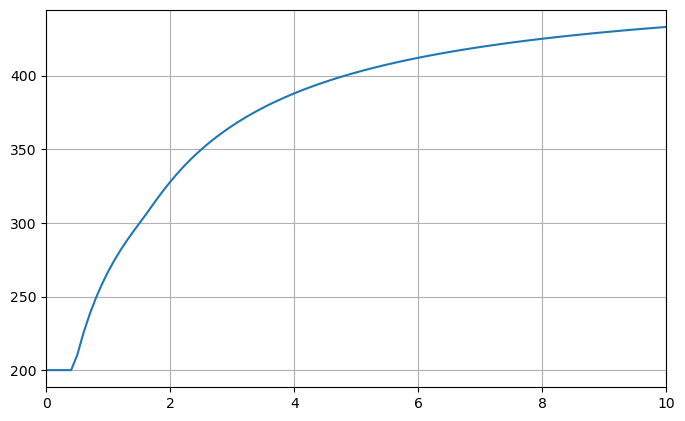

In [69]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(SRs, [out.T for out in outs_by_SR])
plt.xlim(SRs[0],SRs[-1])
plt.grid()
plt.show()